# University of Rhode Island
# Final Project CSC 593, Programming for Scientists, Fall 2019
## Tim Jonas

## 1. Background
### The goal of the research is to determine the influence of different factors (i.e., Traffic, Temperature, and Initial State of Charge) on the energy consumption of electric vehicles in kwH per mile. 
### Data was collected with a Volkswagen eGolf and Data was tracked by a device from fleetcarma that was plugged in the OBD II port of the vehicle. A total of 30 drives was conducted at different days and times. In order to analyze for the influence of traffic, the drives were conducted at different times of the day to create two scenarios (i.e., Traffic [07:00AM - 09:00AM] and No Traffic [Other times]). 15 drives were conducted in each scenario. The data was collected by two graduate students working in the SIS lab of the MCISE department at URI and one undergrad. The project was approved by the IRB. The data represents a sample since the whole EV driver population cannot be covered. The drivers had a similar demographic background and were EV unexperienced in order to minimize the potential influence of the driving style. Since this experiment was conducted in a naturalistic setting all possible factors were controlled to the maximum extend possible (e.g., driving on dry roads, equal music, same settings for air conditioning). However, not all factors could be controlled.
### The raw data had to be cleaned and calculations had to be done in order to apply statistical methods. The following code includes all processes done from the raw data to the results of the statistical analyses.

## 2. Data Processing
### Load Packages

In [1]:
import numpy as np
import pandas as pd
import os
# For changing the time and date
from datetime import datetime, timedelta
# For statistics
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import sklearn 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# For plots
import matplotlib.pyplot as plt
# For linear regression
from sklearn.linear_model import LinearRegression


### Remove or Replace unwanted characters
#### A function is defined below that removes respectively replaces unwanted characters from Columns (e.g., "(", ")", "/"). The initial files as downloaded from the fleetcarma website contained parentheses that are difficult to work with in the code. The function is called "Renamer" and can be used for every driving log.

In [2]:
# Remove unwanted characters from Columns
def renamer(df):
    drive = df.copy()
    drive.columns = drive.columns.str.replace("[", "_")
    drive.columns = drive.columns.str.replace("]","")
    drive.columns = drive.columns.str.replace("(", "_")
    drive.columns = drive.columns.str.replace(")","")
    drive.columns = drive.columns.str.replace("/","")
    drive.columns = drive.columns.str.replace("%","Pctg")
    
    return drive

### Create a list with all files in the the input folder
#### All driving log files are in the folder "InputDataFinalProject". The following code creates a list with all .csv files in the directory. This list is later used for a function that loops through every single file in the directory respectively on the list.

In [3]:
# Print all filenames contained in the folder if it is a .csv file. This is just for controlling reasons.
for filename in os.listdir('../homework/InputDataFinalProject'):
    if filename.endswith(".csv"): 
        print(filename)
# This function adds the name of every file in the directory that ends with ".csv" to the list "fileList". Initially the list is empty and will be filled with the filenames after.
def getFiles():
    fileList = []
    for filename in os.listdir('../homework/InputDataFinalProject'):
        if filename.endswith(".csv"):
            fileList.append(filename)
    
    return fileList


2018-11-29T20-34-18.csv
2018-11-30T15-03-05.csv
2018-11-14T12-52-06.csv
2018-11-27T15-53-11.csv
2018-11-05T21-05-26.csv
2018-11-19T13-01-20_run2.csv
2018-11-27T16-49-43_run2.csv
2018-11-14T19-54-58.csv
2018-11-19T13-01-20_run1.csv
2018-11-27T16-49-43_run1.csv
2018-11-08T15-16-59.csv
2018-11-15T16-47-06.csv
2018-12-04T12-46-28_run1.csv
2018-12-04T12-46-28_run2.csv
2018-11-15T12-47-44.csv
2018-11-08T13-19-45.csv
2018-11-15T13-37-51.csv
2018-11-28T12-26-14.csv
2018-11-14T20-49-28.csv
2018-11-07T19-48-33.csv
2018-11-28T13-17-30.csv
2018-11-07T13-22-03.csv
2018-11-21T15-57-44.csv
2018-11-26T12-34-09.csv
2018-11-29T12-35-21.csv
2018-11-30T15-54-22.csv
2018-11-14T13-37-37.csv
2018-11-21T13-08-24.csv
2018-11-26T19-23-11.csv
2018-11-29T19-33-55.csv


### Create file with summary data
#### The summary file 'TotalDrive' will contain all necessary information from every drive in a comprehensive way. This new data frame can then be used for staistical analysis.

In [4]:
# This defines the columns of the summary file
columns = ['Workbookname','Date','Time','Type','Total Consumption (kWh)','Distance','Mean Consumption','Total Time (ms)','Average Speed','StdDev Speed','Average Acceleration','StdDev Acceleration','Average Jerk','StdDev Jerk','Initial SOC','Temperature']
# This creates the dataframe for the summary data
TotalDrive = pd.DataFrame(columns = columns)

### Loop through all files in the input folder and do all calculations
#### The calculations are needed to transform the raw data into numbers that are needed for the statistical analysis of the data. These numbers contain the speed in meters per second, acceleration, jerk (derivative of acceleration), distance travelled in the second of data tracking, cumulative distance for every data point, consumption for every second in kWh, distance to start point, and distance to end point. The latter is needed to have a uniform lap among all drives. Differences in the distance are due to tracking issues (GPS data was only tracked every four second). Additionally, rows without a GPS signal at the beginning of data collection were deleted. Additionally, a function is implemented in order to separate the drives by their scenario. Scenarios are defined based on daytime. Time and date information was only contained in the name of the file. The name of the file was therefore used to separate the scenarios (i.e., Traffic: 07:00AM - 09:00 AM and No Traffic: Else).


In [5]:
# Loop through the folder and do the following calculations for every single raw data .csv file
fileList = getFiles()
# Start of the loop
for i in range(len(fileList)):
# Open the .csv file and leave out the first 5 rows that did not contain necessary data.
    drive = pd.read_csv('../homework/InputDataFinalProject'+'/'+fileList[i], skiprows= 5, header=0)
# Rename the columes as explained earlier by using the defined funciton renamer.
    drive = renamer(drive)
# Delete empty rows. The GPS tracking started always with a little delay. The empty rows are deleted.
    drive = drive[drive.Longitude_deg != 0]
    # Calculations are sarting below
    # Add column with speed as m_s
    drive['Vehicle Speed_m_s'] = drive['Vehicle Speed_kmh']/3.6
    # Add column with Acceleration
    drive['Vehicle Acceleration'] = drive['Vehicle Speed_m_s'] - drive['Vehicle Speed_m_s'].shift()
    # Add Column with Jerk
    drive['Vehicle Jerk'] = drive['Vehicle Acceleration'] - drive['Vehicle Acceleration'].shift()
    # Add column with distance travelled in that second
    drive['Dist_in_s'] = drive['Vehicle Speed_m_s']/1609.344
    # Add column with cumulative distance
    drive['Cumsum_Dist'] = drive['Dist_in_s'].cumsum()
    # Consumption for every second
    drive['kwh'] = ((drive['HV Battery Current_A'] * drive['HV Battery Voltage_V']*-1)/1000/3600)
    # Add column with distance to start point defined as -41.480337, 71.521673
    drive['Start_Cut'] = ((drive['Latitude_deg']-41.489207)**2)+((drive['Longitude_deg']+71.521673)**2)
    drive['Start_Cut']=np.sqrt((drive['Start_Cut']))
    # Add column with distance to end point defined as -41.480337, 71.525495
    drive['End_Cut'] = ((drive['Latitude_deg']-41.480337)**2)+((drive['Longitude_deg']+71.525495)**2)
    drive['End_Cut'] = np.sqrt((drive['End_Cut']))
    # Delete rows before the closest point to the strating point and after the closest point to the ending point.
    drive.truncate(drive['Start_Cut'].idxmin(),drive['End_Cut'].idxmin())
    # The names of the file contain the time and date of the drive in the following way: Year_Month_Day"T"Hour_Minute_Second.
    # This information contained only in the file name can be used to separate the drives by their scenario.
    # Correct format for Date and Hour in order to run function strftime
    A = fileList[i] # At first is a str
    A = A.replace('T',' ')
    # Separate date and time in order to reformat
    # Define the Date
    B = A[0:11]
    # Define the time
    C = A[11:19]
    # Correct format for Date and Hour in order to run function strftime
    C = C.replace('-',':')
    # Combine renamed date and time 
    D = B+C

    # Convert from string to datetime type
    DateHour = datetime.strptime(D, "%Y-%m-%d %H:%M:%S") 
    # Split only the Date and convert to str again
    Date = DateHour.strftime('%Y-%m-%d') 
    # Time is provided by fleetcarma in Coordinated Universal Time (UTC−05:00). This has to be adjusted to Eastern Daylight Time (EDT).
    # Data collection was happening in autumn/winter. The time difference between UTC and EDT was 5 hours, meaning that ETD was 5 hours behind.
    CorrectHour = DateHour - timedelta(hours=5) 
    # Split only the Date and convert to str again
    Hour = CorrectHour.strftime('%H:%M:%S') 
    # Define 'hour' in a format that can separate the two scenarios Traffic and No traffic
    hour = datetime.strptime(Hour,'%H:%M:%S')
    # The time where traffic was assumed for the study is between 07:00AM and 09:00AM.The boundaries for the traffic scenarios are defined.
    StartTraffic = datetime.strptime("07:00:00", "%H:%M:%S")
    EndTraffic = datetime.strptime("09:00:00", "%H:%M:%S")
    # This function adds a column to the summary data that defines based on the time of the drive whether it is a traffic scenario drive or a no traffic scenario drive.
    if hour >= StartTraffic and hour <= EndTraffic:
        Type = "In Traffic"
    else:
        Type = "No Traffic"
    # Add all the necessary data for statistical analysis from every drive to the summary dataframe 'TotalDrive'.
    TotalDrive = TotalDrive.append({'Workbookname' : fileList[i], 'Date' : Date, 'Time' : Hour, 'Type' : Type, 'Total Consumption (kWh)' : drive['kwh'].sum(), 'Distance' : drive.iloc[-1]['Cumsum_Dist'], 'Mean Consumption' : drive['kwh'].mean(), 'Average Speed' : drive['Vehicle Speed_kmh'].mean(), 'StdDev Speed' : drive['Vehicle Speed_kmh'].std(), 'Average Acceleration' : drive['Vehicle Acceleration'].mean(), 'StdDev Acceleration' : drive['Vehicle Acceleration'].std(), 'Average Jerk' : drive['Vehicle Jerk'].mean(), 'StdDev Jerk' : drive['Vehicle Jerk'].std(), 'Total Time (ms)' : drive.iloc[-1]['Timestamp_ms'] - drive.iloc[0]['Timestamp_ms'], 'Initial SOC' : drive.iloc[0]['HV Battery SOC_Pctg'], 'Temperature' : drive['OAT_degC'].mean()} , ignore_index=True)
    # All data frames with the new columns added are saved as .csv files in the output folder in order to keep the results for every single drive.
    drive.to_csv('../homework/OutputDataFinalProject'+'/'+fileList[i])

## 3. Analysis

### Test the two scenarios for a statistical difference using the paired sampole t-test. The t-test has to be paired because the same drivers were driving in both scenarios.

#### First, the new data frames are created. One has only the Traffic scenario data and the other one only the No Traffic scenario data.

In [6]:
# New data frame with only the traffic scenario data
TotalDriveTraffic = TotalDrive[TotalDrive['Type'].str.contains("In Traffic")]
# This should be saved
TotalDriveTraffic.to_csv('../homework/OutputDataFinalProject'+'/'+'TotalDriveTraffic.csv')
# New data fram with only the no traffic scenario data
TotalDriveNoTraffic = TotalDrive[TotalDrive['Type'].str.contains("No Traffic")]
# This should be saved
TotalDriveTraffic.to_csv('../homework/OutputDataFinalProject'+'/'+'TotalDriveNoTraffic.csv')

#### Second, the two scenarios have to be tested for outliers. This is done based on boxplots.

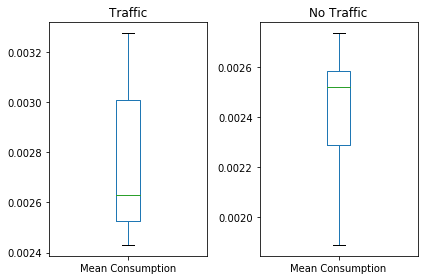

In [7]:
# This defines the plot on the left hand side
plt.subplot(1, 2, 1)
# Title on the left
plt.title('Traffic')
# Data for boxplot left
TotalDriveTraffic['Mean Consumption'].plot(kind='box')
# This defines the plot on the right hand side
plt.subplot(1, 2, 2)
# Title on the right
plt.title('No Traffic')
# Data for plot on the right
TotalDriveNoTraffic['Mean Consumption'].plot(kind='box')
#Increase space between plots
plt.tight_layout()

#### Third, the data has to be tested for normal distribution. A Shapiro-Wilk-Test is used in order to test for normality. 
##### H0: The data is normally distributed.
##### H1: The data is not normally distributed.
##### The 0 hypothesis can be rejected if p < 0.1. An alpha of 0.1 is chosen because data was collected in a naturalistic setting with many uncontrollable factors.
##### The null hypothesis cannot be rejected (p > 0.1). The data is normally distributed.

In [8]:
stats.shapiro(TotalDrive['Mean Consumption'])

(0.9501591324806213, 0.1707274615764618)

#### Fourth, it is tested if the data for the scenarios is significantly different using the paired sample t-test. 
##### H0: The scenarios are not significantly different in terms of average consumption.
##### H1: The scenarios are significantly different in terms of average consumption.
##### The 0 hypothesis can be rejected if p < 0.1. An alpha of 0.1 is chosen because data was collected in a naturalistic setting with many uncontrollable factors.
##### The null hypothesis can be rejected (p<0.1). The result shows that the mean consumption between the two scenarios is significantly different. Now it has to be checked whether this is really based on the traffic volume. First of all, it needs to be proven that traffic was different in the first place.

In [9]:
stats.ttest_rel(TotalDriveTraffic['Mean Consumption'], TotalDriveNoTraffic['Mean Consumption'])

Ttest_relResult(statistic=3.0915662787184743, pvalue=0.007964692340987725)

### Test if traffic is different between the scenarios chosen based on time of day.
#### In order to test the factor traffic for its influence, it has to be proven that there is really a difference within the two scenarios. This is again done by using the paired t-test. Different metrics can be used to analyze for traffic based on car data (i.e., deviation in speed, deviation in acceleration, deviation in jerk as a derivative of acceleration). The procedure is the same a conducted for checking differences in consumption between the scenarios.

#### The two scenarios have to be tested for outliers in terms of deviation of speed. This is done based on boxplots. The plots show outliers.

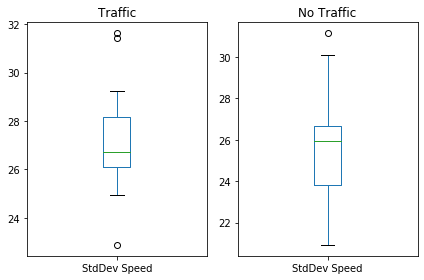

In [10]:
# This defines the plot on the left hand side
plt.subplot(1, 2, 1)
# Title on the left
plt.title('Traffic')
#Data for boxplot left
TotalDriveTraffic['StdDev Speed'].plot(kind='box')
# This defines the plot on the right hand side
plt.subplot(1, 2, 2)
# Title on the right
plt.title('No Traffic')
# Data for plot on the right
TotalDriveNoTraffic['StdDev Speed'].plot(kind='box')
#Increase space between plots
plt.tight_layout()

##### The data has to be tested for normal distribution. A Shapiro-Wilk-Test is used in order to test for normality. 
##### H0: The data is normally distributed.
##### H1: The data is not normally distributed.
##### The 0 hypothesis can be rejected if p < 0.1. An alpha of 0.1 is chosen because data was collected in a naturalistic setting with many uncontrollable factors.
##### The null hypothesis cannot be rejected (p > 0.1). The data is normally distributed.

In [11]:
stats.shapiro(TotalDrive['StdDev Speed'])

(0.9641150236129761, 0.3928055167198181)

#### The t-test is now comparing the standard deviations of speed between the two scenarios.
##### H0: The scenarios are not significantly different in terms of speed.
##### H1: The scenarios are significantly different in terms of speed.
##### The 0 hypothesis can be rejected if p < 0.1. An alpha of 0.1 is chosen because data was collected in a naturalistic setting with many uncontrollable factors.
##### The null hypothesis cannot be rejected (p>0.1). The result shows that the standard deviations of speed between the two scenarios is not significantly different. Speed variation cannot proof that there are differences in traffic between the two scenarios.

In [12]:
stats.ttest_rel(TotalDriveTraffic['StdDev Speed'], TotalDriveNoTraffic['StdDev Speed'])

Ttest_relResult(statistic=1.1906108924360572, pvalue=0.25360330717998253)

#### Standard Deviation of acceleration is tested for differences between the scenarios since in traffic, there are more acceleration and deceleration moments. A difference would indicate driving in higher traffic intensity.
#### The two scenarios have to be tested for outliers. This is done based on boxplots. The plots do not show outliers.

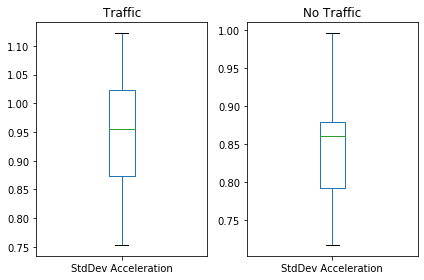

In [13]:
# The code is similar to the one explained before, just adjusted by using different data.
plt.subplot(1, 2, 1)
plt.title('Traffic')
TotalDriveTraffic['StdDev Acceleration'].plot(kind='box')
plt.subplot(1, 2, 2)
plt.title('No Traffic')
TotalDriveNoTraffic['StdDev Acceleration'].plot(kind='box')
plt.tight_layout()

##### The data has to be tested for normal distribution. A Shapiro-Wilk-Test is used in order to test for normality. 
##### H0: The data is normally distributed.
##### H1: The data is not normally distributed.
##### The 0 hypothesis can be rejected if p < 0.1. An alpha of 0.1 is chosen because data was collected in a naturalistic setting with many uncontrollable factors.
##### The null hypothesis cannot be rejected (p > 0.1). The data is normally distributed.

In [14]:
stats.shapiro(TotalDrive['StdDev Acceleration'])

(0.9825308322906494, 0.8881019353866577)

#### The t-test is now comparing the standard deviations of acceleration between the two scenarios.
##### H0: The scenarios are not significantly different in terms of acceleration.
##### H1: The scenarios are significantly different in terms of acceleration.
##### The 0 hypothesis can be rejected if p < 0.1. An alpha of 0.1 is chosen because data was collected in a naturalistic setting with many uncontrollable factors.
##### The null hypothesis can be rejected (p<0.1). The result shows that the standard deviations of acceleration between the two scenarios is  significantly different. Acceleration variation can proof that there are differences in traffic between the two scenarios.

In [15]:
stats.ttest_rel(TotalDriveTraffic['StdDev Acceleration'], TotalDriveNoTraffic['StdDev Acceleration'])

Ttest_relResult(statistic=2.4339063011654987, pvalue=0.02892509293774998)

#### Standard Deviation of jerk as a derivative of acceleration is tested for differences between the scenarios since in traffic, there are higher differences in acceleration and deceleration and thethe difference in jerk is higher. A difference would indicate driving in higher traffic intensity. Jerk is a good metric to proof differences in traffic intensities.
#### The two scenarios have to be tested for outliers. This is done based on boxplots. The plots do not show outliers.

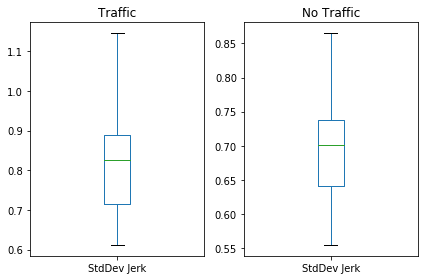

In [16]:
# The code is similar to the one explained before, just adjusted by using different data.
plt.subplot(1, 2, 1)
plt.title('Traffic')
TotalDriveTraffic['StdDev Jerk'].plot(kind='box')
plt.subplot(1, 2, 2)
plt.title('No Traffic')
TotalDriveNoTraffic['StdDev Jerk'].plot(kind='box')
plt.tight_layout()

##### The data has to be tested for normal distribution. A Shapiro-Wilk-Test is used in order to test for normality. 
##### H0: The data is normally distributed.
##### H1: The data is not normally distributed.
##### The 0 hypothesis can be rejected if p < 0.1. An alpha of 0.1 is chosen because data was collected in a naturalistic setting with many uncontrollable factors.
##### The null hypothesis cannot be rejected (p > 0.1). The data is normally distributed.

In [17]:
stats.shapiro(TotalDrive['StdDev Jerk'])

(0.9445026516914368, 0.12028278410434723)

#### The t-test is now comparing the standard deviations of jerk between the two scenarios.
##### H0: The scenarios are not significantly different in terms of jerk.
##### H1: The scenarios are significantly different in terms of jerk.
##### The 0 hypothesis can be rejected if p < 0.1. An alpha of 0.1 is chosen because data was collected in a naturalistic setting with many uncontrollable factors.
##### The null hypothesis can be rejected (p<0.1). The result shows that the standard deviations of acceleration between the two scenarios is  significantly different. Acceleration variation can proof that there are differences in traffic between the two scenarios.

In [18]:
 stats.ttest_rel(TotalDriveTraffic['StdDev Jerk'], TotalDriveNoTraffic['StdDev Jerk'])

Ttest_relResult(statistic=2.3397663988899153, pvalue=0.03463205381816001)

### It is proven that the two scenarios are significantly different based on different metrics.

### Creating a model in order to predict significant factors influencing electric vehicle efficiency
#### All factors are tested for normal distribution in order to apply a multiple linear regression. Again, the sahpiro-wilk test is chosen. All factors are normally distributed (p > 0.1).

In [19]:
print(stats.shapiro(TotalDrive['Temperature']))
print(stats.shapiro(TotalDrive['Mean Consumption']))
print(stats.shapiro(TotalDrive['Initial SOC']))

(0.9690912961959839, 0.5146192312240601)
(0.9501591324806213, 0.1707274615764618)
(0.9614428281784058, 0.33705100417137146)


#### In order to see how different the scenarios are in terms of avergae energy consumption, temperature, Initial SOC, they are plotted and compared visually for both scenatios. 

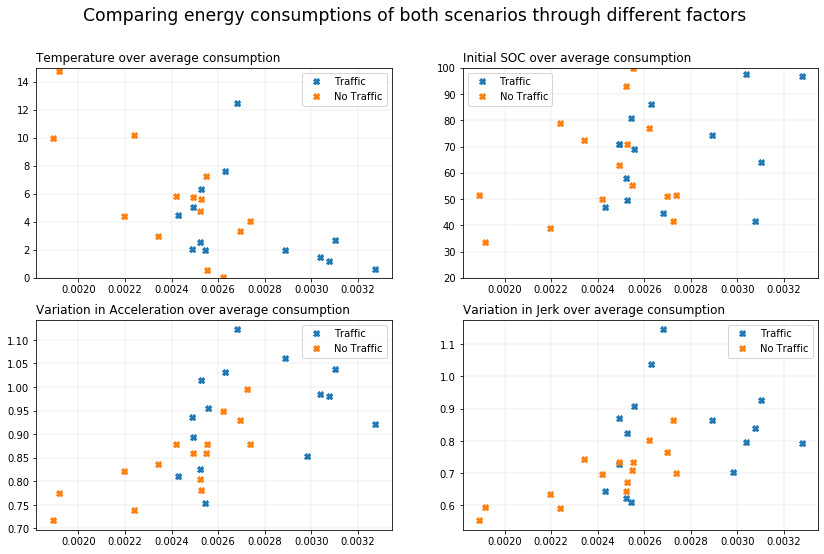

In [20]:
%matplotlib inline
# Four figures are plotted, two in each row
fig, axs = plt.subplots(2, 2, figsize=(14, 8.5))
# Plot of the Temperature over average consumption for drives in both scenarios using different colors in the upper left corner
axs[0][0].plot('Mean Consumption', 'Temperature', 'X', data=TotalDriveTraffic)
axs[0][0].plot('Mean Consumption', 'Temperature', 'X', data=TotalDriveNoTraffic)
# Define the title for the plot in the upper left corner
axs[0][0].set_title('Temperature over average consumption', loc="left")
# Add gridlines (https://towardsdatascience.com/customizing-plots-with-python-matplotlib-bcf02691931f)
axs[0][0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# A legend is defined for better understanding. Orange indicates No Traffic Scenario, blue Traffic Scenario (https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html)
axs[0][0].legend(['Traffic','No Traffic'])
# The limits of the y-axis are defined to make figures in both scenarios more comparable
axs[0][0].set_ylim(0, 15)


# Plot of the Initial state of charge over average consumption for drives in both scenarios using different colors in the upper right corner
# Orange indicates No Traffic Scenario, Blue Traffic Scenario
axs[0][1].plot('Mean Consumption', 'Initial SOC', 'X', data=TotalDriveTraffic)
axs[0][1].plot('Mean Consumption', 'Initial SOC', 'X', data=TotalDriveNoTraffic)
# Define the title for the plot in the upper right corner
axs[0][1].set_title('Initial SOC over average consumption', loc="left")
# Add gridlines (https://towardsdatascience.com/customizing-plots-with-python-matplotlib-bcf02691931f)
axs[0][1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# A legend is defined for better understanding. Orange indicates No Traffic Scenario, blue Traffic Scenario (https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html)
axs[0][1].legend(['Traffic','No Traffic'])
# The limits of the y-axis are defined to make figures in both scenarios more comparable
axs[0][1].set_ylim(20, 100)


# Plot of the Standard Deviation of Acceleration over average consumption for drives in both scenarios using different colors in the lower left corner
# Orange indicates No Traffic Scenario, Blue Traffic Scenario
axs[1][0].plot('Mean Consumption', 'StdDev Acceleration', 'X', data=TotalDriveTraffic)
axs[1][0].plot('Mean Consumption', 'StdDev Acceleration', 'X', data=TotalDriveNoTraffic)
# Define the title for the plot in the lower left corner
axs[1][0].set_title('Variation in Acceleration over average consumption', loc="left")
# Add gridlines (https://towardsdatascience.com/customizing-plots-with-python-matplotlib-bcf02691931f)
axs[1][0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# A legend is defined for better understanding. Orange indicates No Traffic Scenario, blue Traffic Scenario (https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html)
axs[1][0].legend(['Traffic','No Traffic'])


# Plot of the Standard Deviation of Jerk over average consumption for drives in both scenarios using different colors in the lower right corner
# Orange indicates No Traffic Scenario, Blue Traffic Scenario
axs[1][1].plot('Mean Consumption', 'StdDev Jerk', 'X', data=TotalDriveTraffic)
axs[1][1].plot('Mean Consumption', 'StdDev Jerk', 'X', data=TotalDriveNoTraffic)
# Define the title for the plot in the lower right corner
axs[1][1].set_title('Variation in Jerk over average consumption', loc="left")
# Add gridlines (https://towardsdatascience.com/customizing-plots-with-python-matplotlib-bcf02691931f)
axs[1][1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# A legend is defined for better understanding. Orange indicates No Traffic Scenario, blue Traffic Scenario (https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html)
axs[1][1].legend(['Traffic','No Traffic'])

# Set main title for all plots in large letters
plt.suptitle('Comparing energy consumptions of both scenarios through different factors', size='xx-large')

# show plots
plt.show()

#### The plots show that there is are differences in the energy consumption for both scenarios. Additionally, it can be seen that outside temperature seems to have an influence on the energy consumption of electric vehicles. This can not be said about the initial state of charge (SOC). However, the upper right plot still shows the difference in average consumption between the two scenarios. This is especially visible due to the randomized SOC for the test drives. As shown thorugh the paired t-test before, variation in acceleration and jerk are different between the scenarios. This shows the difference in the intensity of traffic between the scenarios.

### Multiple Linear Regression
#### A multiple linear regression is conducted where the average consumption of a drive is the predicted variable (y) and the predictors are Scenario (X1), Temperature (X2), and Initial SOC (X3). 
#### Since the scenario is categorical and not numeric, dummy variables have to be assigned (0 = The driver was not is driving in this scenario; 1 for the driver was driving in the scenario). The column In Traffic will be used as a factor in the linear regression (Driving in Traffic scenario = 1, Driving in No Traffic scenario = 0). Dummies can be assigned using get_dummies as seen below. The results are shown for the first 5 entries.

In [21]:
# Source: https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40
dummy = pd.get_dummies(TotalDrive['Type'])
# Merge the two dataframes in order to add colums with the dummy variables
TotalDrive = pd.concat([TotalDrive, dummy], axis=1)
# Show first 5 rows to check if the merging worked
TotalDrive.head()
# Save final summary file
TotalDrive.to_csv('../homework/OutputDataFinalProject'+'/'+'TotalDrive.csv')

#### After assigning dummy variables, the multiple linear regression can be conducted.

In [22]:
# Define the predictors (i.e., Scenario, Temperature, Initial SOC)
x = sm.add_constant(TotalDrive[['In Traffic', 'Temperature', 'Initial SOC']])
# Define the predicted variable (i.e., Mean Consumption)
y = TotalDrive['Mean Consumption']
# Fit linear model
lmDrive = sm.OLS(y, x).fit()
# Show Summary of the model and ANOVA table
lmDrive.summary()

/Users/timjonas/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Mean Consumption   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     8.733
Date:                Fri, 20 Dec 2019   Prob (F-statistic):           0.000356
Time:                        12:51:18   Log-Likelihood:                 210.33
No. Observations:                  30   AIC:                            -412.7
Df Residuals:                      26   BIC:                            -407.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0025      0.000     16.642      0.000       0.002       0.003
In Traffic      0.0002   8.93e-05      2.625      0.014    5.08e-05       0.000
Temperature -3.662e-05   1.09e-05     -3.347      0.002   -5.91e-05   -1.41e-05
Initial SOC  1.271e-06   1.98e-06      0.642      0.527    -2.8e-06    5.34e-06
==============================================================================
Omnibus:                        2.178   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.337   Jarque-Bera (JB):                1.184
Skew:                          -0.031   Prob(JB):                        0.553
Kurtosis:                       2.029   Cond. No.                         245.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### The results of the multiple linear regression shows a significance of the factors Traffic and Temperature (p<0.05). Initial State of Charge instead is not significant as expected prior to the investigation (p = 0.527). Driving in traffic increases the consumption by 0.0002 kWh/mile compared to driving in the no traffic scenario. The coefficient of determination (R-squared) has a value of 0.444 which means that the model is predicting the response variable y with an accuracy of 44.4%. This sounds small but considering many other factors like driver, humidity, brightness, etc., it is an acceptable value in a naturalistic setting.
#### **Average Consumption(Traffic, Temperature, Initial SOC) = 0.0025 + 0.0002Traffic - 3.662e-05Temperature + 1.271e-06Initial SOC**

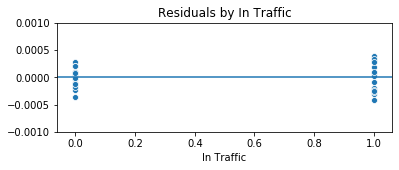

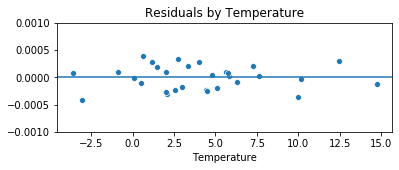

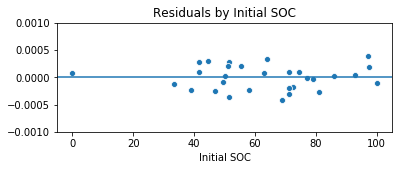

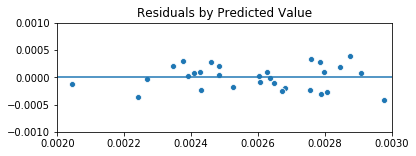

2.47198095326695e-18


In [23]:
for x in (['In Traffic', 'Temperature', 'Initial SOC']):
    #Define Size
    plt.figure(figsize=(6,2))
    sns.scatterplot(TotalDrive[x], lmDrive.resid)
    #Define title 
    plt.title("Residuals by %s" % x)
    # Define limits on y-axis
    plt.ylim(-0.001, 0.001)
    #Put a horizontal line through the mean of the predictions.
    plt.axhline(np.mean(lmDrive.resid))
    #Show Plot
    plt.show()
# Define size
plt.figure(figsize=(6,2))
sns.scatterplot(lmDrive.predict(), lmDrive.resid)
#Define title
plt.title("Residuals by Predicted Value")
# Define limits on y-axis
plt.ylim(-0.001, 0.001)
# Define limits on x-axis
plt.xlim(0.002, 0.003)
#Put a horizontal line through the mean of the predictions.
plt.axhline(np.mean(lmDrive.resid))
# Plot
plt.show()
# print mean value of residuals
print(np.mean(lmDrive.resid))

#### The residual plots for all factors and the predicted value are uniformly distributed. There are no patterns visible.

## 4. Results
#### It can be stated that the traffic and temperature have an influence on the avergage consumption (kWh/mile) of electric vehicles. As expected, initial SOC has no significant impact.